In [17]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    jaccard_score, confusion_matrix, roc_curve, auc
)

In [18]:
df = pd.read_csv('samples_cancer.csv')
df.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [19]:
df.describe()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BlandChrom,NormNucl,Mit,Class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [20]:
df_clean = df.replace('?', pd.NA).dropna()

features = ['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']

for col in features:
    df_clean[col] = pd.to_numeric(df_clean[col])

X = df_clean[features].values
y = df_clean['Class'].map({2: 0, 4: 1}).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [22]:
# Define 4 SVM models
svm_models = {
    'Linear': SVC(kernel='linear', probability=True, random_state=42),
    'Polynomial': SVC(kernel='poly', degree=3, probability=True, random_state=42),
    'RBF': SVC(kernel='rbf', probability=True, random_state=42),
    'Sigmoid': SVC(kernel='sigmoid', probability=True, random_state=42)
}

# Train all models
results = {}

for name, model in svm_models.items():

    # Train
    model.fit(X_train_scaled, y_train)

    # Predict
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    # Calculate metrics
    results[name] = {
        'model': model,
        'accuracy': accuracy_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'jaccard_score': jaccard_score(y_test, y_pred),
        'error_rate': 1 - accuracy_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'probabilities': y_proba
    }

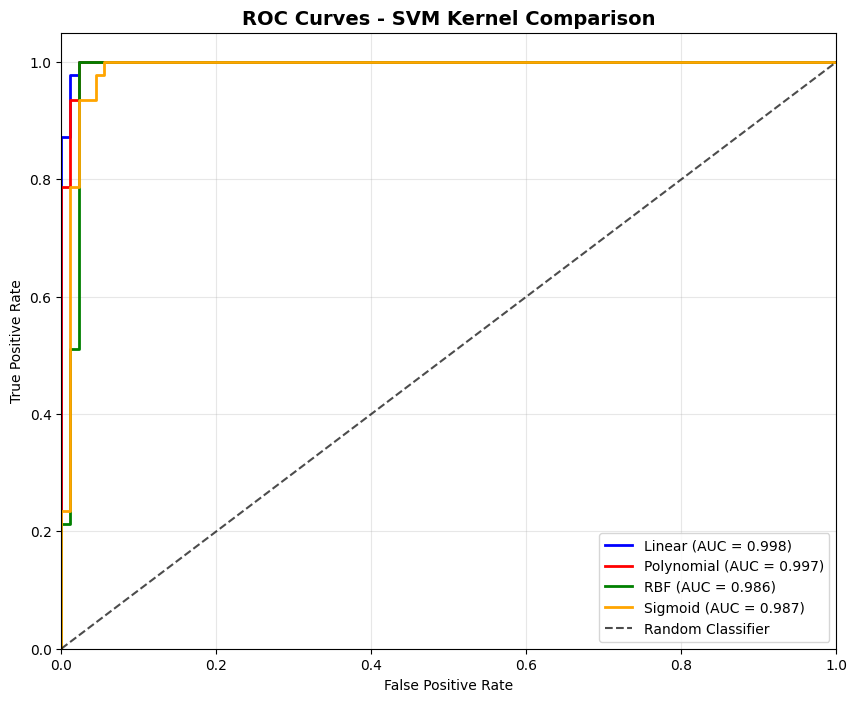

In [23]:
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange']
roc_data = {}

for i, (name, result) in enumerate(results.items()):
    fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
    roc_auc = auc(fpr, tpr)
    roc_data[name] = roc_auc

    plt.plot(fpr, tpr, color=colors[i], linewidth=2,
             label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', alpha=0.7, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - SVM Kernel Comparison', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()